In [1]:
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')

import matplotlib.pyplot as plt

In [2]:
with pd.HDFStore('E:/data/futures.h5') as store:
        print(store.info())
        factors = store['factors2']

<class 'pandas.io.pytables.HDFStore'>
File path: E:/data/futures.h5
/basic                   frame        (shape->[37,11])                             
/daily_price             [invalid_HDFStore node: 'NoneType' object is not iterable]
/daily_price             frame        (shape->[52303,16])                          
/factors                 frame        (shape->[52291,19])                          
/factors2                frame        (shape->[621,2])                             
/logistic                frame        (shape->[52303,7])                           
/quote                   frame        (shape->[1121,2])                            
/randomforest            frame        (shape->[921,2])                             
/support                                                                           


In [3]:
cu = factors.xs('CU', level=1)
select = ['high_low',
          'high_close',
          'close_low',
          'close_open',
          'gap',
          'vol_change',
          'oi_change',
          'efficiency_10d',
          'volatility',
          'skewness',
          'up_break',
          'down_break',
          'weekly_return',
          'momentum_1m', 
          'label']
cu = cu.loc[:, select]
cu.dropna(inplace=True)

In [4]:
cu.shape

(1901, 15)

In [5]:
def gen(x_data, y_data, lookback, min_index, max_index, batch_size=128):
    i = min_index
    while True:
        if i + batch_size > max_index:
            i = min_index #在达到结尾时将i设置为初始点，从而可以一直迭代下去
        rows = np.arange(i-lookback, min(i - lookback + batch_size, max_index))
        i += len(rows)
        samples = np.zeros((len(rows), lookback, x_data.shape[-1])) #一个批量的样本
        targets = np.zeros((len(rows), )) #一个批量的目标
        for j, row in enumerate(rows):
            samples[j] = x_data.iloc[row : row + lookback, :] #选取前lookback日至当前日的特征
            targets[j] = y_data[row] #需要预测的目标
        yield samples, targets

In [6]:
lookback = 240
batch_size = 128
valid_size = 200
train_size = len(cu) - batch_size - valid_size

x_data = cu.iloc[:, :-1]
mean = x_data.iloc[:train_size, :].mean(0)
std = x_data.iloc[:train_size, :].std(0)

x_data -= mean #标准化
x_data /= std

y_data = cu.iloc[:, -1]
y_data.where(y_data == 1, 0.0, inplace=True)#one-hot编码

In [7]:
#生成训练集、验证集、测试集的生成器
train_gen = gen(x_data, y_data, lookback=lookback, 
                min_index=lookback, max_index=train_size, batch_size=batch_size)
valid_gen = gen(x_data, y_data, lookback=lookback, 
              min_index=train_size, max_index=train_size + valid_size, batch_size=batch_size)
test_gen = gen(x_data, y_data, lookback=lookback, 
               min_index=train_size + valid_size, max_index=len(x_data), batch_size=batch_size)

In [8]:
#移动的步数
train_steps = (train_size - lookback) // batch_size
valid_steps = valid_size // batch_size
test_steps = (len(x_data) - train_size - valid_size) // batch_size
print('train steps: %d, \nvalid steps: %d, \ntest steps: %d' % 
      (train_steps, valid_steps, test_steps))

train steps: 10, 
valid steps: 1, 
test steps: 1


In [23]:
from keras import Sequential
from keras.layers import LSTM, Dense
from keras.regularizers import l1_l2

In [10]:
from keras.initializers import constant

In [85]:
#使用LSTM,加入了L2正则化
def build_model():
    model = Sequential()
    model.add(LSTM(64, kernel_regularizer=l1_l2(0, 0.01), return_sequences=True, 
                   input_shape=(lookback, x_data.shape[-1])))
    model.add(LSTM(64, kernel_regularizer=l1_l2(0, 0.01), return_sequences=True))
    model.add(LSTM(32, kernel_regularizer=l1_l2(0, 0.01), return_sequences=True))
    model.add(LSTM(16, kernel_regularizer=l1_l2(0, 0.01)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [86]:
model = build_model()
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=20, 
                    validation_data=valid_gen, validation_steps=valid_steps)

Epoch 1/20
11/11 [==============================] - 24s 2s/step - loss: 2.8466 - acc: 0.4986 - val_loss: 2.5183 - val_acc: 0.5000
Epoch 2/20
11/11 [==============================] - 12s 1s/step - loss: 2.3315 - acc: 0.5156 - val_loss: 2.1319 - val_acc: 0.5000
Epoch 3/20
11/11 [==============================] - 12s 1s/step - loss: 1.9888 - acc: 0.5249 - val_loss: 1.8306 - val_acc: 0.5078
Epoch 4/20
11/11 [==============================] - 12s 1s/step - loss: 1.7141 - acc: 0.5277 - val_loss: 1.5833 - val_acc: 0.5234
Epoch 5/20
11/11 [==============================] - 12s 1s/step - loss: 1.4877 - acc: 0.5291 - val_loss: 1.3792 - val_acc: 0.5234
Epoch 6/20
11/11 [==============================] - 11s 1s/step - loss: 1.3015 - acc: 0.5263 - val_loss: 1.2125 - val_acc: 0.5156
Epoch 7/20
11/11 [==============================] - 12s 1s/step - loss: 1.1505 - acc: 0.5220 - val_loss: 1.0785 - val_acc: 0.5156
Epoch 8/20
11/11 [==============================] - 12s 1s/step - loss: 1.0303 - acc: 0.51

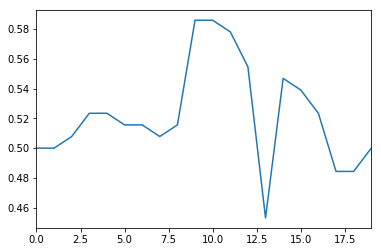

In [87]:
pd.Series(history.history['val_acc']).plot() #在预测正确率上比FNN提高了不少了

In [75]:
#将训练集和验证集合并为训练集
train_size = len(cu) - batch_size

x_data = cu.iloc[:, :-1]
mean = x_data.iloc[:train_size, :].mean(0)
std = x_data.iloc[:train_size, :].std(0)

x_data -= mean
x_data /= std

train_gen = gen(x_data, y_data, lookback=lookback, 
                min_index=lookback, max_index=train_size, batch_size=batch_size)
train_steps = (train_size - lookback) // batch_size

In [101]:
model = build_model()
model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=15)
model.evaluate_generator(test_gen, steps=test_steps)

Epoch 1/15
11/11 [==============================] - 25s 2s/step - loss: 2.8208 - acc: 0.5043
Epoch 2/15
11/11 [==============================] - 13s 1s/step - loss: 2.3115 - acc: 0.5291
Epoch 3/15
11/11 [==============================] - 12s 1s/step - loss: 1.9727 - acc: 0.5298
Epoch 4/15
11/11 [==============================] - 13s 1s/step - loss: 1.7013 - acc: 0.5320
Epoch 5/15
11/11 [==============================] - 13s 1s/step - loss: 1.4780 - acc: 0.5355
Epoch 6/15
11/11 [==============================] - 13s 1s/step - loss: 1.2946 - acc: 0.5305
Epoch 7/15
11/11 [==============================] - 12s 1s/step - loss: 1.1458 - acc: 0.5312
Epoch 8/15
11/11 [==============================] - 14s 1s/step - loss: 1.0274 - acc: 0.5312
Epoch 9/15
11/11 [==============================] - 12s 1s/step - loss: 0.9349 - acc: 0.5270
Epoch 10/15
11/11 [==============================] - 11s 1s/step - loss: 0.8652 - acc: 0.5234
Epoch 11/15
11/11 [==============================] - 11s 1s/step - lo

[0.718576967716217, 0.484375]

In [102]:
y_predict = model.predict_generator(test_gen, steps=test_steps)
y_predict = pd.DataFrame(np.where(y_predict >= 0.5, 1, 0), 
                         index=y_data.index[-batch_size:], columns=['predict'])
records = pd.concat([y_data[-batch_size:], y_predict], axis=1)
records['PL_label'] = np.where(records.label == records.predict, 1, -1)
records['PL_label'] = records['PL_label'].shift(1) #将损益标签向未来移动一个交易日
records.dropna(inplace=True)

In [103]:
with pd.HDFStore('E:/data/futures.h5') as store:
        quote = store['quote']
cu_data = quote.xs('CU', level=1)

In [104]:
import sys
sys.path.append(r'C:\Users\54326\Python_Code\self\paper')

import BackTest as bt

In [105]:
nav = bt.get_nav(records['PL_label'], cu_data['pchg'], trans_cost=0.0002)

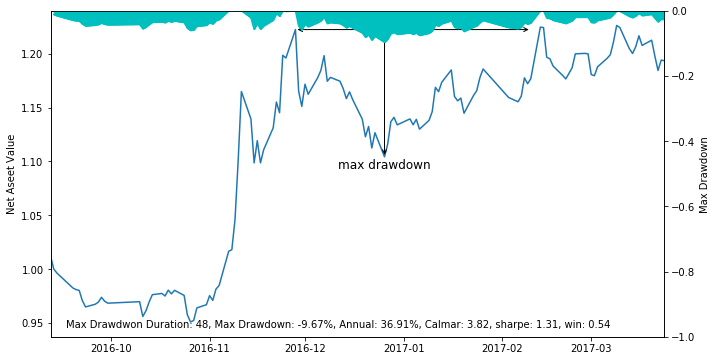

In [106]:
bt.nav_plot(nav, fig_size=(11, 6)) 

#### 在准确率低于0.5的情况下，产生了还不错的收益率？
#### 由于预测结果不稳定，回测结果不是很可靠，可能是因为对于收益率高的交易日预测较为准确
#### 因此尝试一下回归模型

In [118]:
pchg = cu_data['pchg']
pchg = pchg.shift(-1)
pchg = x_data.join(pchg)['pchg']

In [123]:
lookback = 240
batch_size = 128
valid_size = 200
train_size = len(cu) - batch_size - valid_size

x_data = cu.iloc[:, :-1]
mean = x_data.iloc[:train_size, :].mean(0)
std = x_data.iloc[:train_size, :].std(0)

x_data -= mean #标准化
x_data /= std

In [126]:
train_gen = gen(x_data, pchg, lookback=lookback, 
                min_index=lookback, max_index=train_size, batch_size=batch_size)
valid_gen = gen(x_data, pchg, lookback=lookback, 
              min_index=train_size, max_index=train_size + valid_size, batch_size=batch_size)
test_gen = gen(x_data, pchg, lookback=lookback, 
               min_index=train_size + valid_size, max_index=len(x_data), batch_size=batch_size)

In [127]:
train_steps = (train_size - lookback) // batch_size
valid_steps = valid_size // batch_size
test_steps = (len(x_data) - train_size - valid_size) // batch_size
print('train steps: %d, \nvalid steps: %d, \ntest steps: %d' % 
      (train_steps, valid_steps, test_steps))

train steps: 10, 
valid steps: 1, 
test steps: 1


In [128]:
def build_model():
    model = Sequential()
    model.add(LSTM(64, kernel_regularizer=l1_l2(0, 0.01), return_sequences=True, 
                   input_shape=(lookback, x_data.shape[-1])))
    model.add(LSTM(64, kernel_regularizer=l1_l2(0, 0.01), return_sequences=True))
    model.add(LSTM(32, kernel_regularizer=l1_l2(0, 0.01), return_sequences=True))
    model.add(LSTM(16, kernel_regularizer=l1_l2(0, 0.01)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [129]:
model = build_model()
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=20, 
                    validation_data=valid_gen, validation_steps=valid_steps)

Epoch 1/20
10/10 [==============================] - 28s 3s/step - loss: 2.3464 - mean_absolute_error: 0.3631 - val_loss: 1.9192 - val_mean_absolute_error: 0.1100
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 1.7496 - mean_absolute_error: 0.0921 - val_loss: 1.5609 - val_mean_absolute_error: 0.0770
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 1.4269 - mean_absolute_error: 0.0684 - val_loss: 1.2723 - val_mean_absolute_error: 0.0602
Epoch 4/20
10/10 [==============================] - 11s 1s/step - loss: 1.1588 - mean_absolute_error: 0.0540 - val_loss: 1.0270 - val_mean_absolute_error: 0.0482
Epoch 5/20
10/10 [==============================] - 11s 1s/step - loss: 0.9301 - mean_absolute_error: 0.0434 - val_loss: 0.8178 - val_mean_absolute_error: 0.0389
Epoch 6/20
10/10 [==============================] - 11s 1s/step - loss: 0.7359 - mean_absolute_error: 0.0351 - val_loss: 0.6414 - val_mean_absolute_error: 0.0315
Epoch 7/20
10/10 [==========

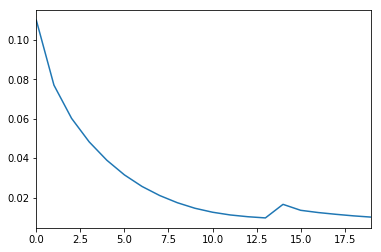

In [134]:
pd.Series(history.history['val_mean_absolute_error']).plot()

In [133]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [135]:
#将训练集和验证集合并为训练集
train_size = len(cu) - batch_size

x_data = cu.iloc[:, :-1]
mean = x_data.iloc[:train_size, :].mean(0)
std = x_data.iloc[:train_size, :].std(0)

x_data -= mean
x_data /= std

train_gen = gen(x_data, pchg, lookback=lookback, 
                min_index=lookback, max_index=train_size, batch_size=batch_size)
train_steps = (train_size - lookback) // batch_size

In [136]:
model = build_model()
model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=15)
model.evaluate_generator(test_gen, steps=test_steps)

Epoch 1/15
11/11 [==============================] - 26s 2s/step - loss: 2.2873 - mean_absolute_error: 0.3350
Epoch 2/15
11/11 [==============================] - 12s 1s/step - loss: 1.6834 - mean_absolute_error: 0.1264
Epoch 3/15
11/11 [==============================] - 13s 1s/step - loss: 1.3326 - mean_absolute_error: 0.0896
Epoch 4/15
11/11 [==============================] - 13s 1s/step - loss: 1.0496 - mean_absolute_error: 0.0695
Epoch 5/15
11/11 [==============================] - 12s 1s/step - loss: 0.8156 - mean_absolute_error: 0.0553
Epoch 6/15
11/11 [==============================] - 12s 1s/step - loss: 0.6232 - mean_absolute_error: 0.0442
Epoch 7/15
11/11 [==============================] - 12s 1s/step - loss: 0.4673 - mean_absolute_error: 0.0354
Epoch 8/15
11/11 [==============================] - 12s 1s/step - loss: 0.3435 - mean_absolute_error: 0.0289
Epoch 9/15
11/11 [==============================] - 12s 1s/step - loss: 0.2473 - mean_absolute_error: 0.0239
Epoch 10/15
11/11 [

[0.02024017460644245, 0.010732457973062992]

In [137]:
y_predict = model.predict_generator(test_gen, steps=test_steps)
y_predict = pd.DataFrame(np.where(y_predict > 0, 1, 0), #预测为正，则买入，负则卖出
                         index=y_data.index[-batch_size:], columns=['predict'])
records = pd.concat([y_data[-batch_size:], y_predict], axis=1)
records['PL_label'] = np.where(records.label == records.predict, 1, -1)
records['PL_label'] = records['PL_label'].shift(1) #将损益标签向未来移动一个交易日
records.dropna(inplace=True)

In [138]:
nav = bt.get_nav(records['PL_label'], cu_data['pchg'], trans_cost=0.0002)

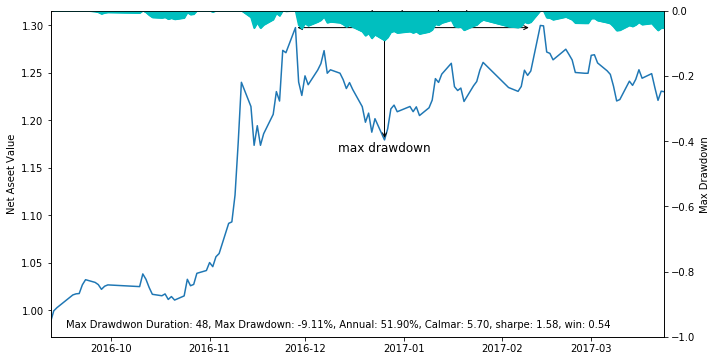

In [139]:
bt.nav_plot(nav, fig_size=(11, 6)) #与分类模型相比，回归模型略好一些